<a href="https://colab.research.google.com/github/aliicee3/LOGML2021-Learning-Latent-Geometries/blob/main/unnecessary_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import random
import numpy as np
import cv2
import base64
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cuda


In [ ]:

# !nvidia-smi

In [3]:
# !unzip /content/drive/MyDrive/datasets/archive.zip

In [4]:
DATASET_PATH ="/content/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/content/drive/MyDrive/datasets/lfw_attributes.txt"

In [5]:
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)
#too much Bush
dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

,person,path
0,Bruce_Van_De_Velde,/content/lfw-deepfunneled/lfw-deepfunneled/Bru...
1,Bruce_Van_De_Velde,/content/lfw-deepfunneled/lfw-deepfunneled/Bru...
2,Iran_Brown,/content/lfw-deepfunneled/lfw-deepfunneled/Ira...
3,Katie_Holmes,/content/lfw-deepfunneled/lfw-deepfunneled/Kat...
4,McGuire_Gibson,/content/lfw-deepfunneled/lfw-deepfunneled/McG...
5,Patrick_Bourrat,/content/lfw-deepfunneled/lfw-deepfunneled/Pat...
6,Kyle_McLaren,/content/lfw-deepfunneled/lfw-deepfunneled/Kyl...
7,Chris_Klein,/content/lfw-deepfunneled/lfw-deepfunneled/Chr...
8,Zulfiqar_Ahmed,/content/lfw-deepfunneled/lfw-deepfunneled/Zul...
9,Robert_Kipkoech_Cheruiyot,/content/lfw-deepfunneled/lfw-deepfunneled/Rob...


In [6]:
def fetch_dataset(dx=80,dy=80, dimx=45,dimy=45):
    
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [13]:
data, attrs = fetch_dataset()

IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]

N_CHANNELS = 3

In [14]:
data = np.array(data / 255, dtype='float32')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [15]:
X_train.shape

(10514, 45, 45, 3)

In [16]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

In [40]:
dim_z = 128

In [41]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(45*45*3, 1500)
        self.fc21 = nn.Linear(1500, dim_z)
        self.fc22 = nn.Linear(1500, dim_z)
        self.fc3 = nn.Linear(dim_z, 1500)
        self.fc4 = nn.Linear(1500, 45*45*3)        
        self.relu = nn.LeakyReLU()

    def encode(self, x):
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = self.relu(self.fc3(z)) #1500
        return torch.sigmoid(self.fc4(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar
    
def loss_vae_fn(x, recon_x, mu, logvar):    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [42]:
model_vae = VAE().to(DEVICE)

In [43]:
def get_batch(data, batch_size=64):
    total_len = data.shape[0]
    for i in range(0, total_len, batch_size):
        yield data[i:min(i+batch_size,total_len)]

def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass
        

def fit_epoch_vae(model, train_x, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)        
        optimizer.zero_grad()
        
        decoded,mu,logvar, = model(inputs)
        outputs = decoded.view(-1, 45*45*3)
        outputs = outputs.to(DEVICE)
        
        loss = loss_vae_fn(inputs,outputs,mu,logvar)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch_vae(model, x_val, batch_size):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val,batch_size=batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            decoded,mu,logvar = model(inputs)
            outputs = decoded.view(-1, 45*45*3)        
            loss = loss_vae_fn(inputs,outputs,mu,logvar)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]         
        pic_input = pic.view(-1, 45*45*3)            
        pic_input = pic_input.to(DEVICE)        
        decoded,mu,logvar = model(inputs)        
        pic_output = decoded[0].view(-1, 45*45*3).squeeze()
        pic_output = pic_output.to("cpu") 
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

def train_vae(train_x, val_x, model, epochs=10, batch_size=32, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch_vae(model,train_x,optimizer,batch_size)
            val_loss = eval_epoch_vae(model,val_x,batch_size)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

epoch:   2%|▏         | 1/50 [00:00<00:23,  2.08it/s]

loss:  506298.664193278

Epoch 001 train_loss: 506298.6642 val_loss: 490637.3415


epoch:   4%|▍         | 2/50 [00:00<00:23,  2.07it/s]

loss:  493555.2029853053

Epoch 002 train_loss: 493555.2030 val_loss: 487186.2525


epoch:   6%|▌         | 3/50 [00:01<00:22,  2.08it/s]

loss:  490853.05782914447

Epoch 003 train_loss: 490853.0578 val_loss: 485062.0391


epoch:   8%|▊         | 4/50 [00:01<00:22,  2.09it/s]

loss:  489067.0089151964

Epoch 004 train_loss: 489067.0089 val_loss: 482807.5779


epoch:  10%|█         | 5/50 [00:02<00:21,  2.10it/s]

loss:  487374.609388375

Epoch 005 train_loss: 487374.6094 val_loss: 483718.4616


epoch:  12%|█▏        | 6/50 [00:02<00:20,  2.11it/s]

loss:  487238.81261443073

Epoch 006 train_loss: 487238.8126 val_loss: 482652.0689


epoch:  14%|█▍        | 7/50 [00:03<00:20,  2.12it/s]

loss:  485291.7854482714

Epoch 007 train_loss: 485291.7854 val_loss: 479700.6990


epoch:  16%|█▌        | 8/50 [00:03<00:19,  2.11it/s]

loss:  484471.88852512126

Epoch 008 train_loss: 484471.8885 val_loss: 479266.4572


epoch:  18%|█▊        | 9/50 [00:04<00:19,  2.12it/s]

loss:  483610.0780269165

Epoch 009 train_loss: 483610.0780 val_loss: 478226.9311


epoch:  20%|██        | 10/50 [00:04<00:19,  2.10it/s]

loss:  484044.4156452111

Epoch 010 train_loss: 484044.4156 val_loss: 479404.7683


epoch:  22%|██▏       | 11/50 [00:05<00:18,  2.10it/s]

loss:  482496.92777635774

Epoch 011 train_loss: 482496.9278 val_loss: 478617.7596


epoch:  24%|██▍       | 12/50 [00:05<00:18,  2.09it/s]

loss:  482254.111204406

Epoch 012 train_loss: 482254.1112 val_loss: 477138.6138


epoch:  26%|██▌       | 13/50 [00:06<00:17,  2.11it/s]

loss:  481940.99902065104

Epoch 013 train_loss: 481940.9990 val_loss: 476656.0186


epoch:  28%|██▊       | 14/50 [00:06<00:17,  2.10it/s]

loss:  481318.3029323997

Epoch 014 train_loss: 481318.3029 val_loss: 477000.7305


epoch:  30%|███       | 15/50 [00:07<00:16,  2.11it/s]

loss:  481122.12867813156

Epoch 015 train_loss: 481122.1287 val_loss: 479288.5472


epoch:  32%|███▏      | 16/50 [00:07<00:16,  2.12it/s]

loss:  481147.59108837025

Epoch 016 train_loss: 481147.5911 val_loss: 476069.2033


epoch:  34%|███▍      | 17/50 [00:08<00:15,  2.10it/s]

loss:  480736.4781422389

Epoch 017 train_loss: 480736.4781 val_loss: 475643.2686


epoch:  36%|███▌      | 18/50 [00:08<00:15,  2.10it/s]

loss:  480567.72238949256

Epoch 018 train_loss: 480567.7224 val_loss: 476387.1823


epoch:  38%|███▊      | 19/50 [00:09<00:14,  2.10it/s]

loss:  481614.30777267215

Epoch 019 train_loss: 481614.3078 val_loss: 476539.7009


epoch:  40%|████      | 20/50 [00:09<00:14,  2.10it/s]

loss:  480500.24086337263

Epoch 020 train_loss: 480500.2409 val_loss: 475360.5613


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
epoch:  42%|████▏     | 21/50 [00:09<00:13,  2.10it/s]

loss:  480082.7829902392

Epoch 021 train_loss: 480082.7830 val_loss: 478047.6076


epoch:  44%|████▍     | 22/50 [00:10<00:13,  2.10it/s]

loss:  480158.8983810277

Epoch 022 train_loss: 480158.8984 val_loss: 475271.4764


epoch:  46%|████▌     | 23/50 [00:10<00:12,  2.10it/s]

loss:  479645.5124595777

Epoch 023 train_loss: 479645.5125 val_loss: 474922.6413


epoch:  48%|████▊     | 24/50 [00:11<00:13,  1.89it/s]

loss:  479408.2348966259

Epoch 024 train_loss: 479408.2349 val_loss: 474563.3201


epoch:  50%|█████     | 25/50 [00:12<00:12,  1.96it/s]

loss:  479285.2362148088

Epoch 025 train_loss: 479285.2362 val_loss: 474567.9712


epoch:  52%|█████▏    | 26/50 [00:12<00:12,  1.98it/s]

loss:  479347.21521304926

Epoch 026 train_loss: 479347.2152 val_loss: 474476.5397


epoch:  54%|█████▍    | 27/50 [00:13<00:11,  1.99it/s]

loss:  478923.7479684825

Epoch 027 train_loss: 478923.7480 val_loss: 474483.0670


epoch:  56%|█████▌    | 28/50 [00:13<00:10,  2.00it/s]

loss:  478891.13007210626

Epoch 028 train_loss: 478891.1301 val_loss: 474710.6265


epoch:  58%|█████▊    | 29/50 [00:14<00:10,  2.03it/s]

loss:  478979.3596811394

Epoch 029 train_loss: 478979.3597 val_loss: 474519.8330


epoch:  60%|██████    | 30/50 [00:14<00:09,  2.05it/s]

loss:  478626.9706953229

Epoch 030 train_loss: 478626.9707 val_loss: 474209.1020


epoch:  62%|██████▏   | 31/50 [00:14<00:09,  2.07it/s]

loss:  478826.9088031434

Epoch 031 train_loss: 478826.9088 val_loss: 474469.9151


epoch:  64%|██████▍   | 32/50 [00:15<00:08,  2.08it/s]

loss:  480008.35718892666

Epoch 032 train_loss: 480008.3572 val_loss: 476086.0814


epoch:  66%|██████▌   | 33/50 [00:15<00:08,  2.08it/s]

loss:  478749.7429142096

Epoch 033 train_loss: 478749.7429 val_loss: 473977.7257


epoch:  68%|██████▊   | 34/50 [00:16<00:07,  2.08it/s]

loss:  478546.07212110044

Epoch 034 train_loss: 478546.0721 val_loss: 474095.0480


epoch:  70%|███████   | 35/50 [00:16<00:07,  2.10it/s]

loss:  478727.11295802024

Epoch 035 train_loss: 478727.1130 val_loss: 473897.6415


epoch:  72%|███████▏  | 36/50 [00:17<00:06,  2.10it/s]

loss:  478391.1004746647

Epoch 036 train_loss: 478391.1005 val_loss: 474429.4447


epoch:  74%|███████▍  | 37/50 [00:17<00:06,  2.10it/s]

loss:  478376.7598871148

Epoch 037 train_loss: 478376.7599 val_loss: 474242.8244


epoch:  76%|███████▌  | 38/50 [00:18<00:05,  2.09it/s]

loss:  478030.79494602437

Epoch 038 train_loss: 478030.7949 val_loss: 473542.2082


epoch:  78%|███████▊  | 39/50 [00:18<00:05,  2.09it/s]

loss:  478490.39816851343

Epoch 039 train_loss: 478490.3982 val_loss: 476625.5680


epoch:  80%|████████  | 40/50 [00:19<00:04,  2.10it/s]

loss:  478228.46136698686

Epoch 040 train_loss: 478228.4614 val_loss: 473390.7204


epoch:  82%|████████▏ | 41/50 [00:19<00:04,  2.11it/s]

loss:  477794.5919651774

Epoch 041 train_loss: 477794.5920 val_loss: 473236.5867


epoch:  84%|████████▍ | 42/50 [00:20<00:03,  2.11it/s]

loss:  477766.8375350723

Epoch 042 train_loss: 477766.8375 val_loss: 473117.7834


epoch:  86%|████████▌ | 43/50 [00:20<00:03,  2.12it/s]

loss:  477746.25572896854

Epoch 043 train_loss: 477746.2557 val_loss: 475050.1965


epoch:  88%|████████▊ | 44/50 [00:21<00:02,  2.11it/s]

loss:  477878.7205244198

Epoch 044 train_loss: 477878.7205 val_loss: 473130.3088


epoch:  90%|█████████ | 45/50 [00:21<00:02,  2.11it/s]

loss:  477687.00649877544

Epoch 045 train_loss: 477687.0065 val_loss: 474320.1194


epoch:  92%|█████████▏| 46/50 [00:22<00:01,  2.12it/s]

loss:  477579.8328731334

Epoch 046 train_loss: 477579.8329 val_loss: 473693.8746


epoch:  94%|█████████▍| 47/50 [00:22<00:01,  2.09it/s]

loss:  477524.38314241724

Epoch 047 train_loss: 477524.3831 val_loss: 473470.5463


epoch:  96%|█████████▌| 48/50 [00:23<00:00,  2.10it/s]

loss:  477382.94797412975

Epoch 048 train_loss: 477382.9480 val_loss: 473549.8155


epoch:  98%|█████████▊| 49/50 [00:23<00:00,  2.10it/s]

loss:  477617.157425516

Epoch 049 train_loss: 477617.1574 val_loss: 473254.8044


epoch: 100%|██████████| 50/50 [00:24<00:00,  2.08it/s]

loss:  477428.2343021804

Epoch 050 train_loss: 477428.2343 val_loss: 473913.1955


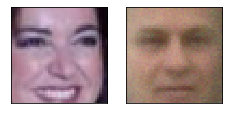

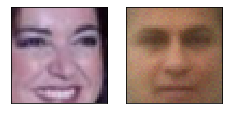

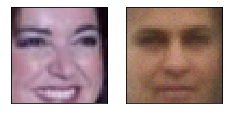

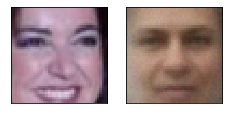

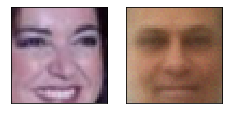

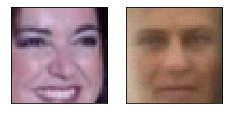

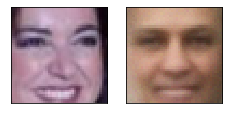

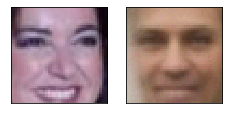

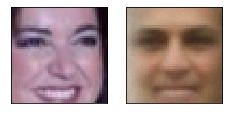

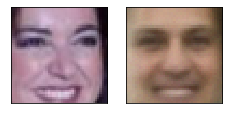

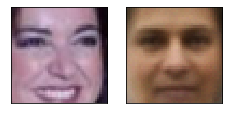

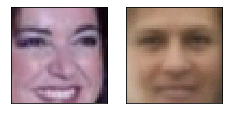

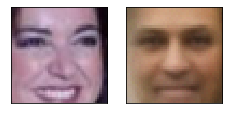

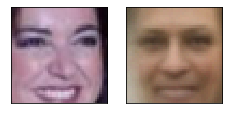

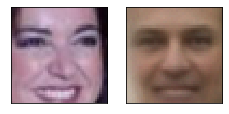

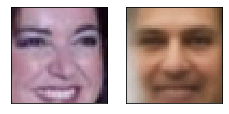

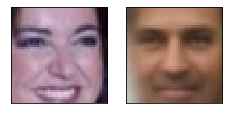

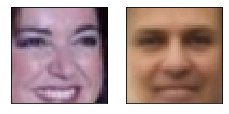

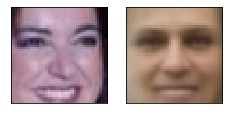

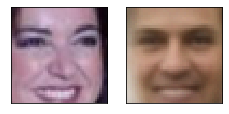

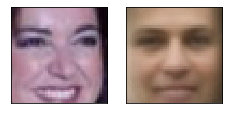

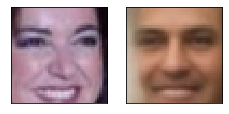

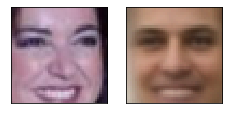

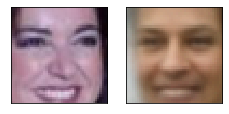

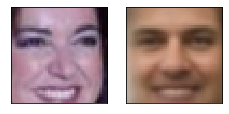

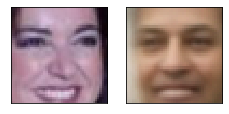

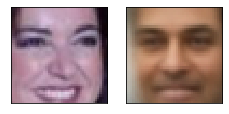

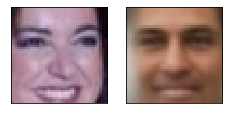

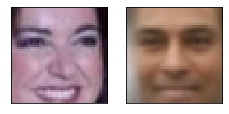

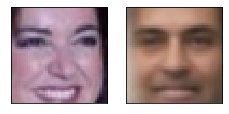

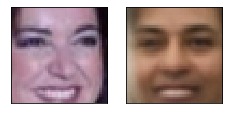

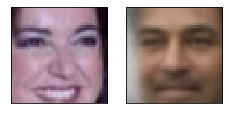

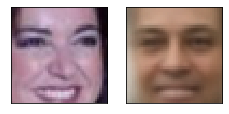

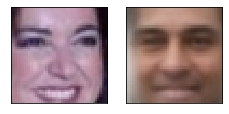

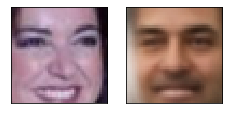

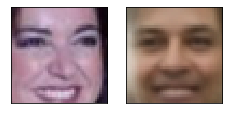

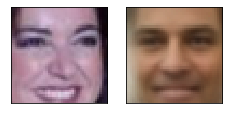

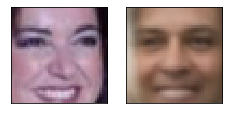

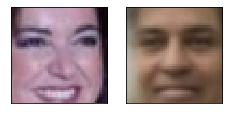

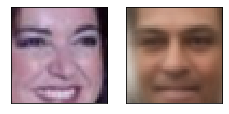

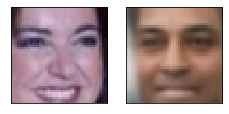

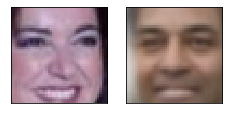

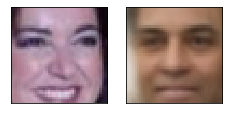

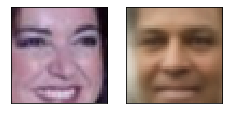

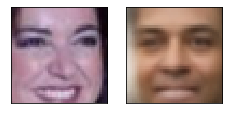

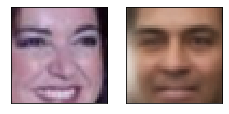

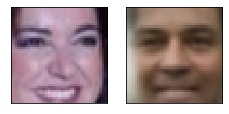

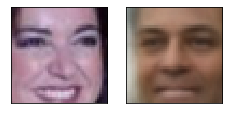

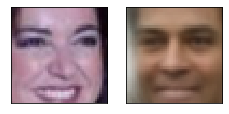

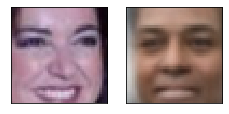

In [44]:
history_vae = train_vae(X_train, X_val, model_vae, epochs=50, batch_size=128, lr=0.001)

(50, 128)


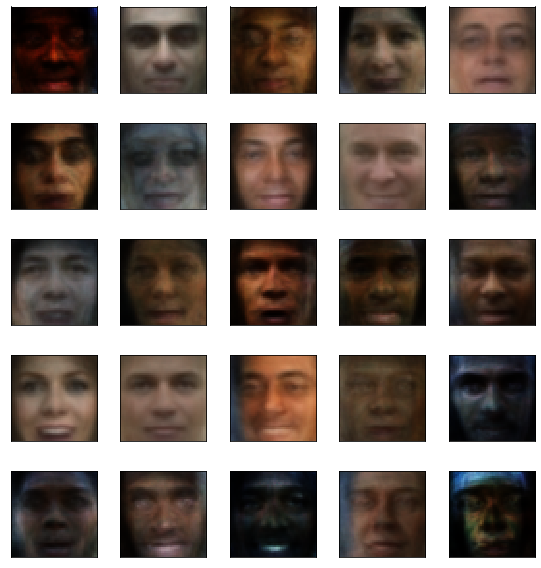

In [45]:
z = np.random.randn(50, dim_z)
print(z.shape)

with torch.no_grad():
    inputs = torch.FloatTensor(z)    
    inputs = inputs.to(DEVICE)
    model_vae.eval()
    output = model_vae.decode(inputs)
    plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)
        

In [56]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).iloc[100:125].index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(25).index.values
no_smile_data = data[no_smile_ids]

eyeglasses_ids = attrs['Eyeglasses'].sort_values(ascending=False).head(25).index.values
eyeglasses_data = data[eyeglasses_ids]

sunglasses_ids = attrs['Sunglasses'].sort_values(ascending=False).head(25).index.values
sunglasses_data = data[sunglasses_ids]

In [57]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

In [58]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

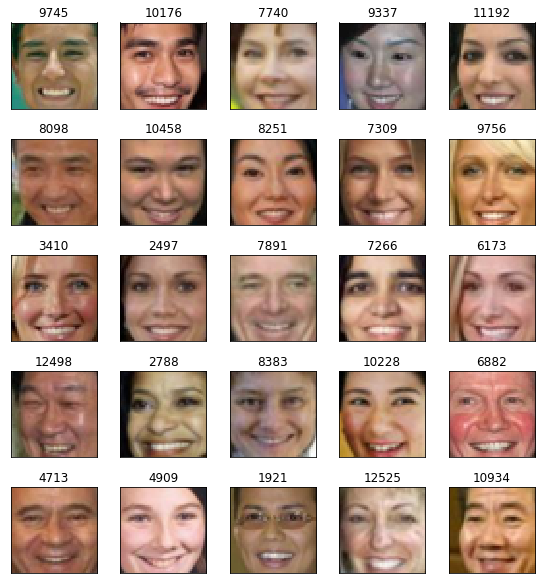

In [59]:
plot_gallery(smile_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=smile_ids)

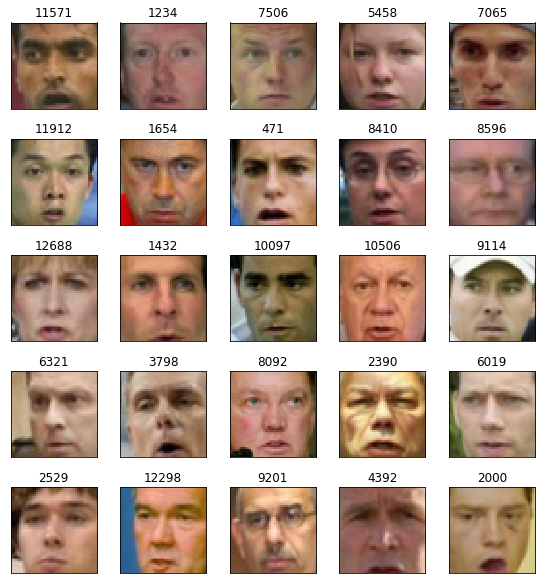

In [60]:
plot_gallery(no_smile_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=no_smile_ids)

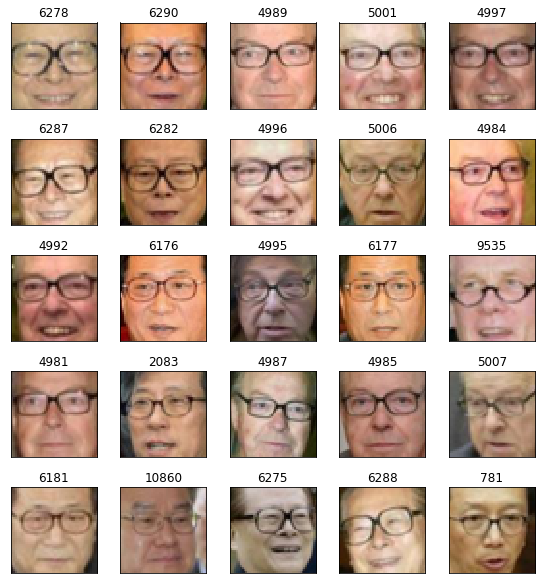

In [61]:
plot_gallery(eyeglasses_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=eyeglasses_ids)

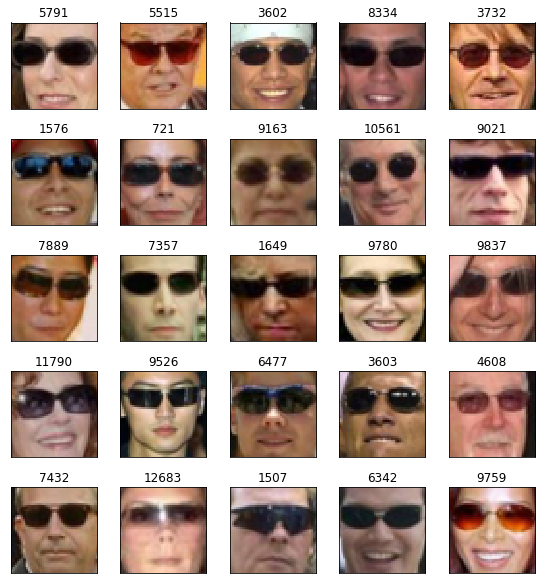

In [62]:
plot_gallery(sunglasses_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=sunglasses_ids)

In [63]:
def to_latent(pic):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic.reshape(-1, 45*45*3))
        inputs = inputs.to(DEVICE)
        model_vae.eval()
        mean, sd = model_vae.encode(inputs)        
        return mean

def from_latent(vec):
    with torch.no_grad():
        inputs = vec.to(DEVICE)
        model_vae.eval()
        output = model_vae.decode(inputs)        
        return output

In [64]:
smile_latent = to_latent(smile_data).mean(axis=0)
no_smile_latent = to_latent(no_smile_data).mean(axis=0)
sunglasses_latent = to_latent(sunglasses_data).mean(axis=0)

smile_vec = smile_latent-no_smile_latent
sunglasses_vec = sunglasses_latent - smile_latent

def make_me_smile(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += smile_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
        
def give_me_sunglasses(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += sunglasses_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


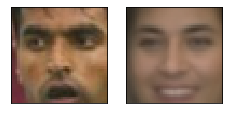

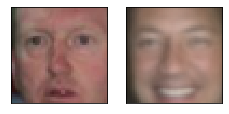

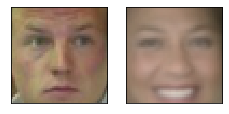

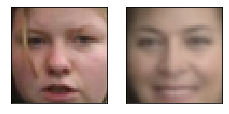

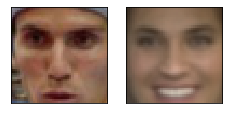

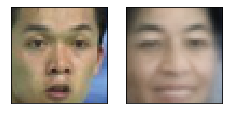

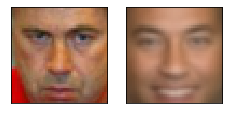

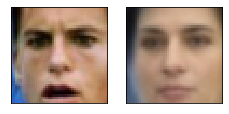

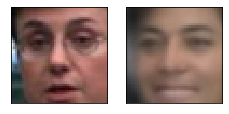

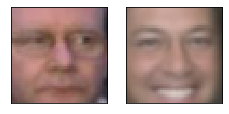

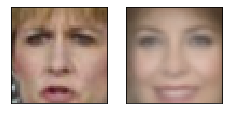

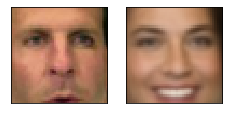

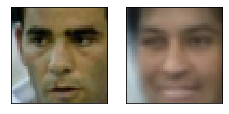

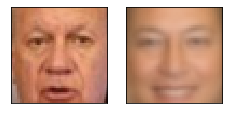

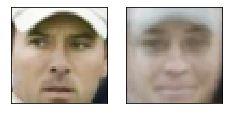

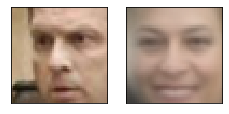

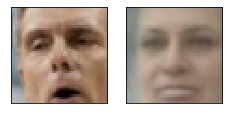

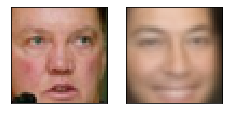

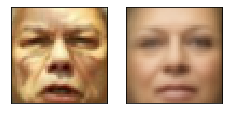

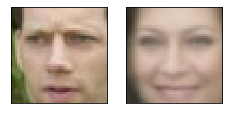

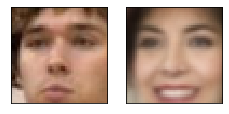

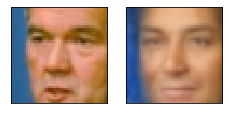

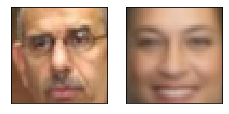

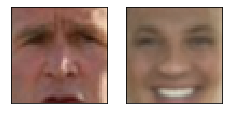

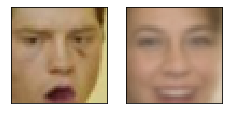

In [66]:
make_me_smile(no_smile_ids)